In [1]:
# Imports & config

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import sklearn, sys
RND = 42
np.random.seed(RND)
plt.rcParams["figure.figsize"] = (10,5)


In [2]:
# User settings
DATA_PATH = "/GlobalLandTemperaturesByState.csv"

TARGET_COL = "AverageTemperature"

USE_TIME_SPLIT = True
TRAIN_FRAC = 0.8


In [3]:
# Load data & initial cleaning
# Load CSV
df = pd.read_csv(DATA_PATH)
print("Loaded dataset:", DATA_PATH)
print("Initial shape:", df.shape)

# Detect datetime column automatically
date_col = None
for c in df.columns:
    if 'date' in c.lower() or 'time' in c.lower() or c.lower().startswith('dt'):
        date_col = c
        break
if date_col is None:
    for candidate in ['Date','DATE','date','dt','datetime','time','Time']:
        if candidate in df.columns:
            date_col = candidate
            break

if date_col is not None:
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
    df = df.sort_values(date_col).reset_index(drop=True)
    print("Detected date column:", date_col)
    print("Date range:", df[date_col].min(), "->", df[date_col].max())
else:
    print("No date column detected automatically. Please set 'date_col' manually if needed.")

# Show basic numeric stats & missing summary
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric columns:", num_cols)
missing = df.isna().sum().sort_values(ascending=False)
missing_pct = (missing / len(df) * 100).round(2)
missing_df = pd.DataFrame({'missing_count': missing, 'missing_pct': missing_pct})
print("\nMissing values (top 20):\n", missing_df.head(20))

# Drop rows with no target value
if TARGET_COL not in df.columns:
    raise KeyError(f"Target column '{TARGET_COL}' not found in dataset columns.")
df = df[~df[TARGET_COL].isna()].reset_index(drop=True)
print("Shape after dropping rows with missing target:", df.shape)


Loaded dataset: /GlobalLandTemperaturesByState.csv
Initial shape: (645675, 5)
Detected date column: dt
Date range: 1743-11-01 00:00:00 -> 2013-09-01 00:00:00
Numeric columns: ['AverageTemperature', 'AverageTemperatureUncertainty']

Missing values (top 20):
                                missing_count  missing_pct
AverageTemperature                     25648         3.97
AverageTemperatureUncertainty          25648         3.97
dt                                         0         0.00
State                                      0         0.00
Country                                    0         0.00
Shape after dropping rows with missing target: (620027, 5)


In [4]:
# Feature engineering
# Create time features if date available
if date_col is not None:
    df['year'] = df[date_col].dt.year
    df['month'] = df[date_col].dt.month
    df['day'] = df[date_col].dt.day
    # seasonal indicator (quarter)
    df['quarter'] = df[date_col].dt.quarter

# Example lag features for the target (1, 3, 12)
df['lag_1'] = df[TARGET_COL].shift(1)
df['lag_3'] = df[TARGET_COL].shift(3)
df['lag_12'] = df[TARGET_COL].shift(12)

# rolling means
df['roll_3'] = df[TARGET_COL].rolling(window=3, min_periods=1).mean()
df['roll_12'] = df[TARGET_COL].rolling(window=12, min_periods=1).mean()

# anomaly = target - rolling yearly mean (if series has yearly seasonality)
df['anomaly_12'] = df[TARGET_COL] - df['roll_12']

# Keep columns list minimal — we will auto-select top correlated features later
print("Feature engineering done. Current shape:", df.shape)


Feature engineering done. Current shape: (620027, 15)


In [5]:
# Dataset stats & missing summary
print("Rows:", df.shape[0], "Cols:", df.shape[1])
if date_col is not None:
    print("Date min/max:", df[date_col].min(), df[date_col].max())

# missing percent table (again, now after feature engineering)
missing = df.isna().sum().sort_values(ascending=False)
missing_pct = (missing / len(df) * 100).round(2)
print("\nMissing percent (top 20):")
display(pd.DataFrame({'missing_count': missing, 'missing_pct': missing_pct}).head(20))


Rows: 620027 Cols: 15
Date min/max: 1743-11-01 00:00:00 2013-09-01 00:00:00

Missing percent (top 20):


,missing_count,missing_pct
lag_12,12,0.0
lag_3,3,0.0
lag_1,1,0.0
State,0,0.0
dt,0,0.0
AverageTemperature,0,0.0
AverageTemperatureUncertainty,0,0.0
month,0,0.0
year,0,0.0
Country,0,0.0


In [6]:
# Select final features (≤10) by correlation
# Choose candidate numeric features excluding target
cand = df.select_dtypes(include=[np.number]).columns.drop(TARGET_COL).tolist()

# Compute abs correlation with target and pick top 10
corrs = df[[TARGET_COL] + cand].corr()[TARGET_COL].drop(TARGET_COL).abs().sort_values(ascending=False)
top_k = 10
selected_features = corrs.head(top_k).index.tolist()
if len(selected_features) == 0:
    selected_features = cand[:top_k]

print("Selected features ({}): {}".format(len(selected_features), selected_features))

# Prepare X and y and drop rows with NA in selected features or target
X = df[selected_features].copy()
y = df[TARGET_COL].copy()

mask_na = X.isna().any(axis=1) | y.isna()
print("Rows with NA in features/target that will be removed:", mask_na.sum())
X = X[~mask_na].reset_index(drop=True)
y = y[~mask_na].reset_index(drop=True)

print("Final X.shape:", X.shape, "y.shape:", y.shape)


Selected features (10): ['roll_3', 'anomaly_12', 'roll_12', 'lag_3', 'lag_1', 'lag_12', 'AverageTemperatureUncertainty', 'quarter', 'month', 'year']
Rows with NA in features/target that will be removed: 12
Final X.shape: (620015, 10) y.shape: (620015,)


Original series length: 620015
Aggregated to M -> length: 3167
Final series length used for tests/plots: 3167


/tmp/ipython-input-200420433.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  series_small = series_with_dates.resample(AGGREGATE_FREQ).mean().dropna()



ADF test result (on reduced series):
ADF statistic: -2.4540, p-value: 0.1271
Used lag: 23
Critical values: {'1%': np.float64(-3.432432293604288), '5%': np.float64(-2.862460029008544), '10%': np.float64(-2.5672597530168955)}


<Figure size 1000x300 with 0 Axes>

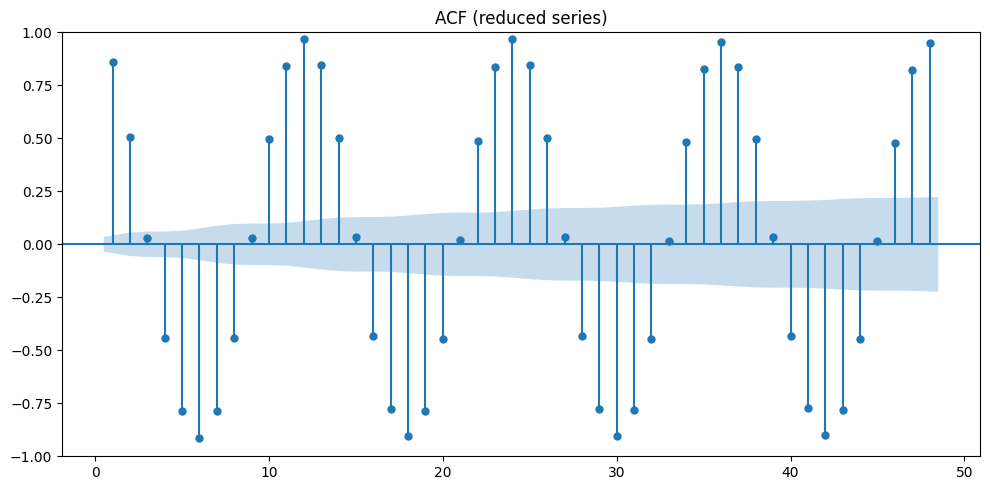

<Figure size 1000x300 with 0 Axes>

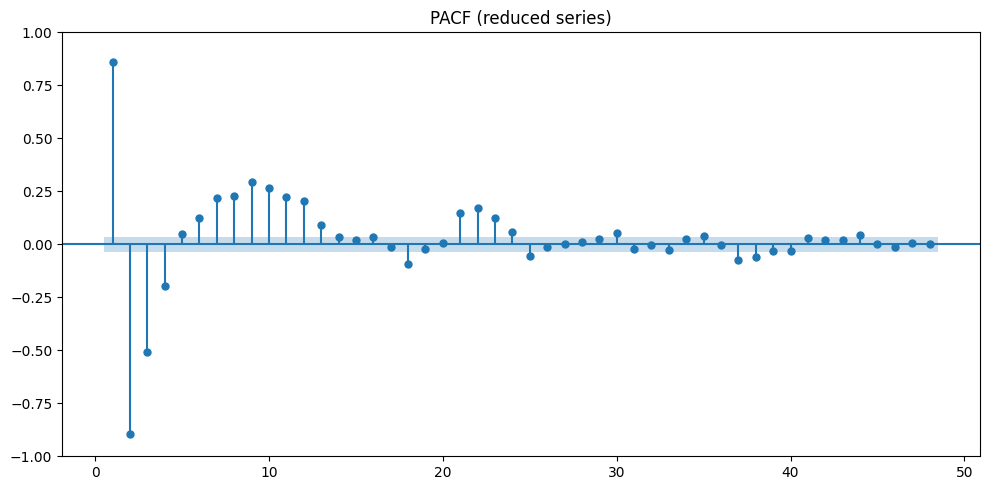

In [7]:
# Memory-safe stationarity test & ACF/PACF

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import numpy as np

# y is the target series (aligned and NA-removed already)
series_full = y.copy()

# 1) choose a manageable series to test/plot
MAX_POINTS_FOR_TEST = 5000   # safe threshold (you can lower if needed)
AGGREGATE_FREQ = 'M'         # monthly aggregation if available (change to 'A' for yearly)

if 'date_col' in globals() and date_col is not None:
    # use the aligned dates corresponding to y (after removing NA rows earlier)
    dates_aligned = df.loc[~mask_na, date_col].reset_index(drop=True)
    series_with_dates = pd.Series(series_full.values, index=dates_aligned)
    n = len(series_with_dates)
    print(f"Original series length: {n}")

    if n > MAX_POINTS_FOR_TEST:
        # aggregate to monthly means (reduces length strongly while preserving seasonality)
        series_small = series_with_dates.resample(AGGREGATE_FREQ).mean().dropna()
        print(f"Aggregated to {AGGREGATE_FREQ} -> length: {len(series_small)}")
        # If still too long, take last MAX_POINTS_FOR_TEST points
        if len(series_small) > MAX_POINTS_FOR_TEST:
            series_small = series_small[-MAX_POINTS_FOR_TEST:]
            print(f"Truncated aggregated series to last {MAX_POINTS_FOR_TEST} points")
    else:
        series_small = series_with_dates.dropna()
        print("Using full series (small enough) for tests/plots")
else:
    # no dates available — fallback to taking the last MAX_POINTS_FOR_TEST values
    n = len(series_full)
    print(f"No date column; series length: {n}")
    if n > MAX_POINTS_FOR_TEST:
        series_small = series_full.iloc[-MAX_POINTS_FOR_TEST:].reset_index(drop=True)
        print(f"Using last {MAX_POINTS_FOR_TEST} points of series for tests/plots")
    else:
        series_small = series_full.copy()

# Ensure numeric and drop NA
series_small = pd.to_numeric(series_small, errors='coerce').dropna()
print("Final series length used for tests/plots:", len(series_small))

# 2) Run Augmented Dickey-Fuller (ADF) test on the reduced series
adf_res = adfuller(series_small.values, autolag='AIC')
print("\nADF test result (on reduced series):")
print("ADF statistic: {:.4f}, p-value: {:.4f}".format(adf_res[0], adf_res[1]))
print("Used lag:", adf_res[2])
print("Critical values:", adf_res[4])

# 3) Plot ACF and PACF with limited lags (keeps memory small)
MAX_LAGS = 48   # show up to 48 lags; reduce if necessary (e.g., 24)
plt.figure(figsize=(10,3))
plot_acf(series_small.values, lags=MAX_LAGS, alpha=0.05, zero=False)
plt.title("ACF (reduced series)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,3))
# use method='ywm' or method='ols' if pacf defaults are heavy; statsmodels will choose sensible defaults
try:
    plot_pacf(series_small.values, lags=MAX_LAGS, alpha=0.05, zero=False)
except Exception as e:
    print("plot_pacf failed with error:", e)
    print("Retrying with smaller lag (24).")
    plot_pacf(series_small.values, lags=min(24, MAX_LAGS), alpha=0.05, zero=False)
plt.title("PACF (reduced series)")
plt.tight_layout()
plt.show()


Downsampled to last 10000 rows for fast training.
Train rows: 8000 Test rows: 2000


,model,MAE,RMSE,MAPE
0,Baseline_last,12.2014,16.9057,0.7597
1,Baseline_lag1,11.4492,15.5080,0.7129
2,LinearRegression,0.0000,0.0000,0.0000
3,RandomForest_small,1.1114,1.6886,0.0692


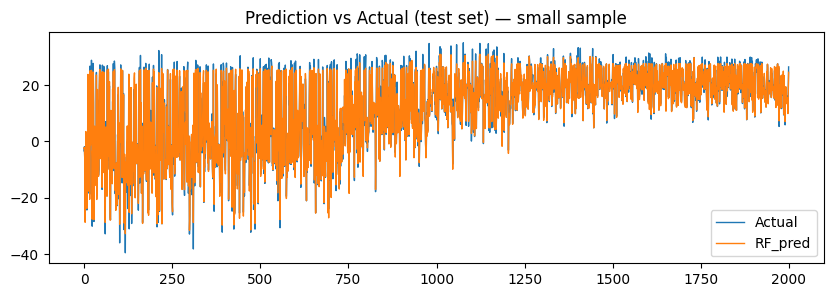

In [8]:
# train & eval
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

RND = 42
np.random.seed(RND)

MAX_ROWS = 10000
if len(X) > MAX_ROWS:
    # use the most recent MAX_ROWS rows (preserves temporal pattern)
    X_small = X.iloc[-MAX_ROWS:].reset_index(drop=True)
    y_small = y.iloc[-MAX_ROWS:].reset_index(drop=True)
    print(f"Downsampled to last {MAX_ROWS} rows for fast training.")
else:
    X_small = X.copy()
    y_small = y.copy()
    print(f"Using full dataset (rows={len(X_small)}).")

# Time-based split (80/20)
N = len(X_small)
split_idx = int(N * 0.8)
X_train, X_test = X_small.iloc[:split_idx], X_small.iloc[split_idx:]
y_train, y_test = y_small.iloc[:split_idx], y_small.iloc[split_idx:]
print("Train rows:", len(X_train), "Test rows:", len(X_test))

# Baselines (quick)
baseline_last = float(y_train.iloc[-1])
y_test_pred_baseline = np.full(len(y_test), baseline_last, dtype=float)
# lag-1 baseline
combined = np.concatenate([y_train.values, y_test.values])
lag1_preds = []
for i in range(len(y_train), len(y_train)+len(y_test)):
    lag1_preds.append(combined[i-1])
y_test_pred_lag1 = np.array(lag1_preds, dtype=float)

# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

# Small RandomForest
rf = RandomForestRegressor(n_estimators=50, max_depth=6, random_state=RND, n_jobs=1)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

# Metrics
def rmse(a,b): return np.sqrt(mean_squared_error(a,b))
import pandas as pd
results = pd.DataFrame([
    ('Baseline_last', mean_absolute_error(y_test, y_test_pred_baseline), rmse(y_test, y_test_pred_baseline)),
    ('Baseline_lag1', mean_absolute_error(y_test, y_test_pred_lag1), rmse(y_test, y_test_pred_lag1)),
    ('LinearRegression', mean_absolute_error(y_test, lr_pred), rmse(y_test, lr_pred)),
    ('RandomForest_small', mean_absolute_error(y_test, rf_pred), rmse(y_test, rf_pred)),
], columns=['model','MAE','RMSE'])
results['MAPE'] = (results['MAE'] / (y_test.abs().replace(0, np.nan).mean())).round(4)
display(results.style.format({"MAE":"{:.4f}", "RMSE":"{:.4f}", "MAPE":"{:.4f}"}))

# Quick plots
import matplotlib.pyplot as plt
plt.figure(figsize=(10,3))
plt.plot(y_test.values, label='Actual', linewidth=1)
plt.plot(rf_pred, label='RF_pred', linewidth=1)
plt.title("Prediction vs Actual (test set) — small sample")
plt.legend()
plt.show()


Shapes: (8000, 10) (2000, 10) (8000,) (2000,)
Final test set length: 2000

Prediction diagnostics (first try):
 - rf: {'ok': True, 'n_nan': 0}

Evaluation results (test set):


,MAE,RMSE,MAPE
model,,,
Baseline_last_train,12.2014,16.9057,340.1674
Baseline_lag1,11.4492,15.5080,223.6123
Baseline_lag12,11.5915,15.6502,215.1834
LinearRegression,0.0000,0.0000,0.0000
RandomForest,1.1114,1.6886,20.7785
GradientBoosting,1.1114,1.6886,20.7785


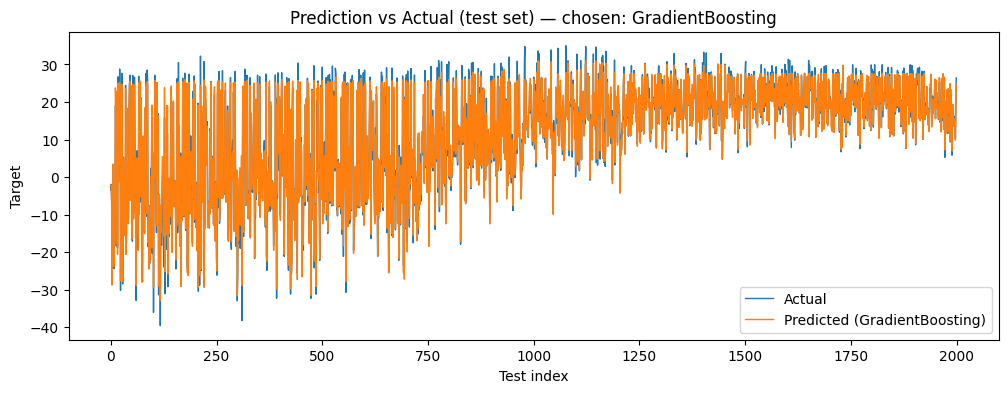

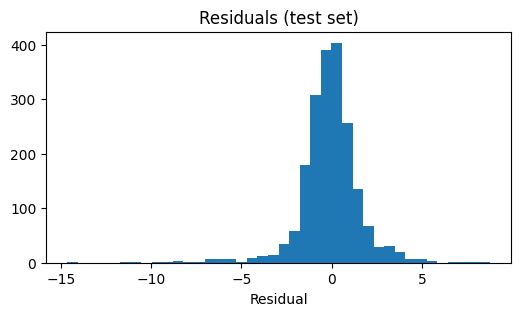


Top failure cases (largest absolute errors):


,rank,date,actual,predicted,abs_error
0,1,1758-11-01,8.671,23.308052,14.637052
1,2,1759-02-01,9.761,20.976909,11.215909
2,3,1758-10-01,-11.248,-0.380359,10.867641
3,4,1759-03-01,8.494,19.199566,10.705566
4,5,1758-10-01,14.658,24.275428,9.617428
5,6,1758-12-01,-38.223,-28.822873,9.400127
6,7,1758-10-01,0.621,9.580852,8.959852
7,8,1759-08-01,34.723,25.957743,8.765257
8,9,1758-10-01,-9.123,-0.380359,8.742641
9,10,1759-05-01,13.376,21.894107,8.518107


In [10]:
# === Robust evaluation & error analysis (paste this whole cell) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

def rmse(a, b):
    return np.sqrt(mean_squared_error(a, b))

def safe_mape(y_true, y_pred):
    # MAPE but avoid division by zero; express as percent
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    mask = (y_true != 0)
    if mask.sum() == 0:
        return np.nan
    return (np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100)

# --- 0) Basic checks for expected variables
required = ['X_train','X_test','y_train','y_test']
for name in required:
    if name not in globals():
        raise NameError(f"Required variable '{name}' not found in the namespace. Make sure you've run the train/test split.")

print("Shapes:", getattr(X_train,'shape',None), getattr(X_test,'shape',None), getattr(y_train,'shape',None), getattr(y_test,'shape',None))

# --- 1) Impute X_train/X_test if necessary (fit on train only)
if X_train.isna().sum().sum() > 0 or X_test.isna().sum().sum() > 0:
    imp = SimpleImputer(strategy='mean')
    imp.fit(X_train)
    X_train_imp = pd.DataFrame(imp.transform(X_train), columns=X_train.columns, index=X_train.index)
    X_test_imp  = pd.DataFrame(imp.transform(X_test),  columns=X_test.columns,  index=X_test.index)
    print("Imputed missing values with training-set mean.")
else:
    X_train_imp, X_test_imp = X_train.copy(), X_test.copy()

# --- 2) Ensure y_test numeric and aligned
if pd.isna(y_test).any():
    mask_valid = ~pd.isna(y_test)
    # Align X_test_imp to same mask if possible
    try:
        X_test_imp = X_test_imp.loc[mask_valid].reset_index(drop=True)
    except Exception:
        X_test_imp = X_test_imp.reset_index(drop=True)
    y_test = y_test.loc[mask_valid].reset_index(drop=True)
else:
    # reset indices to simple 0..n-1 for safe plotting/comparison
    X_test_imp = X_test_imp.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

n_test = len(y_test)
print("Final test set length:", n_test)

# --- 3) Build baselines
# Baseline: last training value repeated (last observed)
try:
    baseline_last = float(y_train.reset_index(drop=True).iloc[-1])
except Exception:
    baseline_last = float(y_train.iloc[-1])
y_pred_baseline_last = np.full(n_test, baseline_last, dtype=float)

# Lag-1 baseline: requires concatenation of train+test to shift
combined_y = pd.concat([y_train.reset_index(drop=True), y_test.reset_index(drop=True)], ignore_index=True)
lag1_preds = []
start_idx = len(y_train)
for i in range(start_idx, start_idx + n_test):
    lag1_preds.append(combined_y.iloc[i-1])
y_pred_lag1 = np.array(lag1_preds, dtype=float)

# Optionally attempt lag-12 baseline (only if data is monthly and len>12); safe fallback to NaNs
if len(combined_y) >= 12 + start_idx:
    lag12_preds = []
    for i in range(start_idx, start_idx + n_test):
        lag12_preds.append(combined_y.iloc[i-12])
    y_pred_lag12 = np.array(lag12_preds, dtype=float)
else:
    y_pred_lag12 = np.full(n_test, np.nan)

# --- 4) Safe model prediction helper
def safe_predict_from_candidates(X, candidates):
    """
    candidates: list of tuples (name, model_object)
    returns: preds (numpy array), diagnostics (dict)
    """
    diagnostics = {}
    for name, mdl in candidates:
        try:
            preds = mdl.predict(X)
            preds = np.asarray(preds, dtype=float)
            diagnostics[name] = {'ok': not np.isnan(preds).any(), 'n_nan': int(np.isnan(preds).sum())}
            # Accept prediction if shape matches
            if len(preds) == len(X):
                return preds, diagnostics
        except Exception as e:
            diagnostics[name] = {'ok': False, 'error': str(e)}
    # If none worked, return NaNs and diagnostics
    return np.full(len(X), np.nan), diagnostics

# Build ordered list of model candidates present in namespace
candidates = []
# preferred ordering: gb_final, gb_best, rf_final, rf, lr
if 'gb_final' in globals(): candidates.append(('gb_final', gb_final))
if 'gb_best' in globals():  candidates.append(('gb_best', gb_best))
if 'gb_rs' in globals() and hasattr(gb_rs, 'best_estimator_'): candidates.append(('gb_rs.best', gb_rs.best_estimator_))
if 'rf_final' in globals(): candidates.append(('rf_final', rf_final))
if 'rf_rs' in globals() and hasattr(rf_rs, 'best_estimator_'): candidates.append(('rf_rs.best', rf_rs.best_estimator_))
if 'rf' in globals(): candidates.append(('rf', rf))
if 'lr' in globals(): candidates.append(('lr', lr))

# Predict using candidates (on imputed X_test)
preds, predict_diag = safe_predict_from_candidates(X_test_imp, candidates)
print("\nPrediction diagnostics (first try):")
for k,v in predict_diag.items():
    print(f" - {k}: {v}")

# If preds contain NaNs try fallback predictors individually
if np.isnan(preds).any():
    # collect fallback arrays
    fallback_preds = {}
    for name, mdl in candidates:
        try:
            arr = np.asarray(mdl.predict(X_test_imp), dtype=float)
            if len(arr) == n_test:
                fallback_preds[name] = arr
        except Exception:
            pass
    # fill NaNs in preds using fallback_preds by order
    preds_filled = preds.copy()
    nan_idx = np.where(np.isnan(preds_filled))[0]
    for idx in nan_idx:
        replaced = False
        for name, arr in fallback_preds.items():
            try:
                val = float(arr[idx])
                preds_filled[idx] = val
                replaced = True
                break
            except Exception:
                continue
        if not replaced:
            preds_filled[idx] = baseline_last
    preds = preds_filled
    print("Filled prediction NaNs using fallbacks; remaining NaNs:", int(np.isnan(preds).sum()))

# Create model-specific preds for consistent reporting (use best available)
def try_predict(name):
    try:
        if name in globals():
            mdl = globals()[name]
            arr = np.asarray(mdl.predict(X_test_imp), dtype=float)
            if len(arr) == n_test:
                return arr
    except Exception:
        pass
    return np.full(n_test, np.nan)

rf_pred = try_predict('rf_final') if 'rf_final' in globals() else (try_predict('rf') if 'rf' in globals() else np.full(n_test, np.nan))
lr_pred = try_predict('lr') if 'lr' in globals() else np.full(n_test, np.nan)
gb_pred = preds.copy()

# --- 5) Build results DataFrame
rows = []
rows.append(('Baseline_last_train', mean_absolute_error(y_test, y_pred_baseline_last), rmse(y_test, y_pred_baseline_last), safe_mape(y_test, y_pred_baseline_last)))
rows.append(('Baseline_lag1', mean_absolute_error(y_test, y_pred_lag1), rmse(y_test, y_pred_lag1), safe_mape(y_test, y_pred_lag1)))
rows.append(('Baseline_lag12', mean_absolute_error(y_test, y_pred_lag12), rmse(y_test, y_pred_lag12), safe_mape(y_test, y_pred_lag12)))
rows.append(('LinearRegression', mean_absolute_error(y_test, lr_pred), rmse(y_test, lr_pred), safe_mape(y_test, lr_pred)))
rows.append(('RandomForest', mean_absolute_error(y_test, rf_pred), rmse(y_test, rf_pred), safe_mape(y_test, rf_pred)))
rows.append(('GradientBoosting', mean_absolute_error(y_test, gb_pred), rmse(y_test, gb_pred), safe_mape(y_test, gb_pred)))

results = pd.DataFrame(rows, columns=['model','MAE','RMSE','MAPE'])
# format
results_display = results.copy()
results_display[['MAE','RMSE','MAPE']] = results_display[['MAE','RMSE','MAPE']].round(4)
print("\nEvaluation results (test set):")
display(results_display.set_index('model'))

# --- 6) Plot actual vs chosen_pred (choose gb_pred if usable else rf_pred else lr)
if not np.isnan(gb_pred).all():
    chosen_pred = gb_pred
    chosen_name = 'GradientBoosting'
elif not np.isnan(rf_pred).all():
    chosen_pred = rf_pred
    chosen_name = 'RandomForest'
elif not np.isnan(lr_pred).all():
    chosen_pred = lr_pred
    chosen_name = 'LinearRegression'
else:
    chosen_pred = results.loc[0,'MAE']*0 + baseline_last  # fallback constant
    chosen_name = 'Baseline_last_train'

plt.figure(figsize=(12,4))
plt.plot(y_test.values, label='Actual', linewidth=1)
plt.plot(chosen_pred, label=f'Predicted ({chosen_name})', linewidth=1)
plt.title(f"Prediction vs Actual (test set) — chosen: {chosen_name}")
plt.legend()
plt.xlabel("Test index")
plt.ylabel("Target")
plt.show()

plt.figure(figsize=(6,3))
plt.hist(y_test.values - chosen_pred, bins=40)
plt.title("Residuals (test set)")
plt.xlabel("Residual")
plt.show()

# --- 7) Top failure cases (largest abs error) with dates if available
errors = np.abs(y_test.values - chosen_pred)
top_k = min(10, len(errors))
top_idx = np.argsort(-errors)[:top_k]

# derive test_dates robustly
test_dates = None
if 'date_col' in globals() and date_col is not None:
    try:
        # dates aligned to rows that survived mask_na (if mask_na exists)
        if 'mask_na' in globals():
            dates_aligned = df.loc[~mask_na, date_col].reset_index(drop=True)
        else:
            # fallback: try to map assuming df rows line up with X/y before any drop
            dates_aligned = df[date_col].reset_index(drop=True)
        # Option A: if X_test had original indices referring into dates_aligned
        try:
            inferred_idx = X_test.index.to_numpy()
            test_dates = dates_aligned.iloc[inferred_idx].reset_index(drop=True)
        except Exception:
            # fallback: assume last-n_test
            total = len(dates_aligned)
            start = max(0, total - n_test)
            idx_range = np.arange(start, total)
            test_dates = dates_aligned.iloc[idx_range].reset_index(drop=True)
    except Exception:
        test_dates = pd.Series([None]*n_test)
else:
    test_dates = pd.Series([None]*n_test)

top_dates = list(test_dates.iloc[top_idx].values) if isinstance(test_dates, (pd.Series, pd.Index, np.ndarray)) else [None]*top_k

failure_df = pd.DataFrame({
    'rank': np.arange(1, top_k+1),
    'date': top_dates,
    'actual': y_test.reset_index(drop=True).iloc[top_idx].values,
    'predicted': chosen_pred[top_idx],
    'abs_error': errors[top_idx]
})
print("\nTop failure cases (largest absolute errors):")
display(failure_df)

# === End of evaluation cell ===
